In [67]:
import numpy as np
import pandas as pd

df = pd.read_csv('./Train_X.csv',encoding= 'cp950')

In [68]:
df = df.sort_values('日期')

In [69]:
stock_list = (df['股票代號'].unique()).tolist()

In [70]:
#df[df['股票代號']==stock_list[0]]['收盤價']

In [71]:
data = {}
for name in stock_list:
    data[name]=df[df['股票代號']==name].loc[:,['開盤價', '最高價','最低價','收盤價','成交量.股.']]

In [72]:
#定義正規化函式
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

a= normalize(data['2455'])

,開盤價,最高價,最低價,收盤價,成交量.股.
29038,0.017632,0.026985,0.017051,0.035465,-0.013452
27360,0.012045,-0.023862,0.017051,-0.010689,-0.063189
25680,0.000872,0.043934,0.022179,0.035465,0.007484
24000,0.051151,0.026985,0.042692,0.045721,-0.057653
22319,0.062325,0.038285,0.052948,0.045721,-0.020774
20638,0.056738,0.060883,0.011923,-0.005561,-0.011409
18957,-0.015888,-0.006913,0.022179,-0.000433,-0.070987
17276,-0.010301,0.055234,0.027307,0.091875,0.008359
15593,0.090258,0.106081,0.068333,0.040593,0.118870
13909,0.051151,0.026985,0.058076,0.040593,-0.056160


In [73]:
#定義餵入的feature跟label序列
def train_(df, ref_day=10, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]['收盤價']))
    return np.array(X_train), np.array(Y_train)

In [74]:
X,Y=train_(a,5,1)
split_boundary = int(X.shape[0] * 0.9)
train_x = X[: split_boundary]
test_x = X[split_boundary:]
train_y = Y[: split_boundary]
test_y = Y[split_boundary:]

In [76]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()
regressor.add(LSTM(units = 250, return_sequences = True, input_shape = (train_x.shape[1], train_x.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 250, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 250, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 250))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(train_x, train_y, epochs = 100, batch_size = 32)

Epoch 1/100
207/207 [==============================] - 7s 34ms/step - loss: 0.0356
Epoch 2/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0127
Epoch 3/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0123
Epoch 4/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0103
Epoch 5/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0105
Epoch 6/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0097
Epoch 7/100
207/207 [==============================] - 1s 7ms/step - loss: 0.0094
Epoch 8/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0090
Epoch 9/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0084
Epoch 10/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0088
Epoch 11/100
207/207 [==============================] - 1s 7ms/step - loss: 0.0077
Epoch 12/100
207/207 [==============================] - 2s 7ms/step - loss: 0.0065
Epoch 13/100

207/207 [==============================] - 2s 8ms/step - loss: 0.0042
Epoch 100/100
207/207 [==============================] - 2s 9ms/step - loss: 0.0037


In [77]:
#估算test
regressor.evaluate(test_x,test_y)

24/24 [==============================] - 3s 111ms/step


0.0016503281658515334

In [82]:
test_y

,0
0,28.50
1,28.55
2,28.05
3,27.25
4,27.50
5,27.60
6,27.80
7,27.65
8,28.40
9,28.10


In [78]:
predict_y = regressor.predict(test_x)

In [79]:
def denormalize(train):
    denorm = train*(np.max(data['2455']['收盤價'])-np.min(data['2455']['收盤價']))+np.mean(data['2455']['收盤價'])
    return denorm

In [80]:
test_y = pd.DataFrame(test_y)
test_y = denormalize(test_y)
z = denormalize(predict_y)

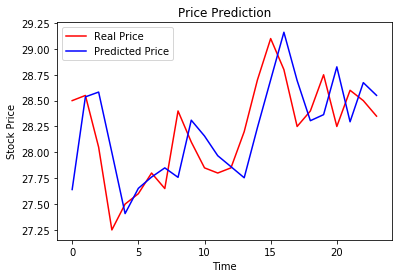

In [81]:
import matplotlib.pyplot as plt 
plt.plot(test_y, color = 'red', label = 'Real Price')  # 紅線表示真實股價
plt.plot(z, color = 'blue', label = 'Predicted Price')  # 藍線表示預測股價
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()